In [33]:
import sys

sys.path.append("..")

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

from src.util import *
from src.model import *

tqdm.pandas()

In [35]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

In [36]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)

In [37]:
feature_df = (
    interaction_df[interaction_df.timestamp < train_split_date]
    .sort_values("timestamp")
    .reset_index(drop=True)
)
target_df = (
    interaction_df[
        (interaction_df.timestamp >= train_split_date)
        & (interaction_df.timestamp < test_split_date)
    ]
    .sort_values("timestamp")
    .reset_index(drop=True)
)
test_df = (
    interaction_df[interaction_df.timestamp >= test_split_date]
    .sort_values("timestamp")
    .reset_index(drop=True)
)

sequences = feature_df.groupby("user_id").item_id.agg(list).to_dict()
user_features = create_user_features(feature_df=feature_df, split_date=train_split_date)
user_embedding_weight = torch.from_numpy(user_features.values.astype(np.float32))

train_clv_dict, train_target_items = create_targets(target_df=target_df)
test_clv_dict, test_target_items = create_targets(target_df=test_df)

train_dataset = Dataset(
    sequences=sequences,
    clv_dict=train_clv_dict,
    target_items=train_target_items,
)
test_dataset = Dataset(
    sequences=sequences,
    clv_dict=test_clv_dict,
    target_items=test_target_items,
)

100%|██████████| 25093/25093 [00:00<00:00, 197629.28it/s]


,recency,tenure,frequency,clv
recency,1.000000,-0.329792,-0.311994,-0.316822
tenure,-0.329792,1.000000,0.584697,0.287682
frequency,-0.311994,0.584697,1.000000,0.327789
clv,-0.316822,0.287682,0.327789,1.000000


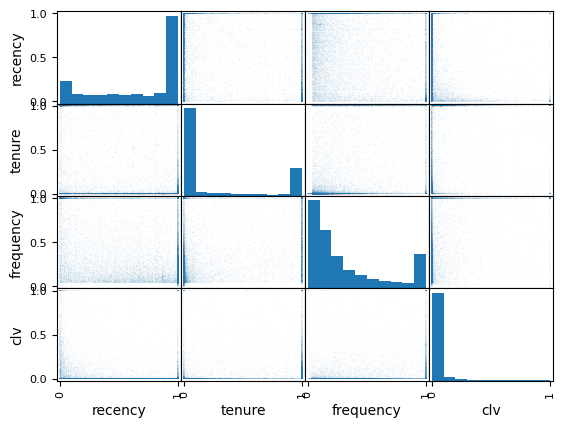

In [38]:
a = pd.Series(train_clv_dict).rename("clv").to_frame()
a.index = a.index.rename("user_id")
a = pd.merge(user_features, a, on="user_id", how="left")
a = a.fillna(0)
pd.plotting.scatter_matrix(a, alpha=0.1, s=1)
a.corr()

In [39]:
b = pd.Series(test_clv_dict).rename("clv").to_frame()
b.index = b.index.rename("user_id")
b = pd.merge(user_features, b, on="user_id", how="left")
b = b.fillna(0)

In [40]:
a_train, a_valid = train_test_split(a, test_size=0.2)

X_train = a_train.drop("clv", axis=1)
y_train = a_train["clv"]

X_valid = a_valid.drop("clv", axis=1)
y_valid = a_valid["clv"]

X_test = b.drop("clv", axis=1)
y_test = b["clv"]

params = {
    "objective": "regression",
    "metrics": "mae"
}

train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_valid, y_valid)
test_set = lgb.Dataset(X_test, y_test)

model = lgb.train(params, train_set=train_set, valid_sets=[valid_set])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 20074, number of used features: 3
[LightGBM] [Info] Start training from score 0.045280


In [54]:
y_pred = model.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.24594612720308728